# The random walk revisited

We are going to analyze the random walk on a $d$-dimensional lattice in $d=1,2,3$ with periodic boundary conditions. To do so we will use a `struct Lattice` that generates neighbors for lattices in arbitrary dimensions, defined in the `lattice.jl` file.

In [2]:
using PyPlot, SpecialFunctions, Revise
includet("lattice.jl")

Let's see an example for a 3-d cubic lattice of size $5\times 5 \times 5$

In [3]:
mydims = (5,5,5)
L = Lattice(mydims) # note that I could have used Lattice(5,5,5)

3-D lattice dims = 5×5×5 PBC

To figure out what is going on, let's print the `LinearIndex`, the `CartesianIndex` and the neighbors' list for each site of the lattice. Note that the functions `lin2cart` is defined in `lattice.jl`. Note also the idiomatic syntax for dispatching on a function of more than one input using the syntax `Ref` on the 2nd argument of the function `lin2cart`.

In [4]:
[vec(L.site) lin2cart.(L.site, Ref(L.dims)) L.neig]

125×3 Matrix{Any}:
   1  (1, 1, 1)  [5, 21, 101, 2, 6, 26]
   2  (2, 1, 1)  [1, 22, 102, 3, 7, 27]
   3  (3, 1, 1)  [2, 23, 103, 4, 8, 28]
   4  (4, 1, 1)  [3, 24, 104, 5, 9, 29]
   5  (5, 1, 1)  [4, 25, 105, 1, 10, 30]
   6  (1, 2, 1)  [10, 1, 106, 7, 11, 31]
   7  (2, 2, 1)  [6, 2, 107, 8, 12, 32]
   8  (3, 2, 1)  [7, 3, 108, 9, 13, 33]
   9  (4, 2, 1)  [8, 4, 109, 10, 14, 34]
  10  (5, 2, 1)  [9, 5, 110, 6, 15, 35]
   ⋮             
 117  (2, 4, 5)  [116, 112, 92, 118, 122, 17]
 118  (3, 4, 5)  [117, 113, 93, 119, 123, 18]
 119  (4, 4, 5)  [118, 114, 94, 120, 124, 19]
 120  (5, 4, 5)  [119, 115, 95, 116, 125, 20]
 121  (1, 5, 5)  [125, 116, 96, 122, 101, 21]
 122  (2, 5, 5)  [121, 117, 97, 123, 102, 22]
 123  (3, 5, 5)  [122, 118, 98, 124, 103, 23]
 124  (4, 5, 5)  [123, 119, 99, 125, 104, 24]
 125  (5, 5, 5)  [124, 120, 100, 121, 105, 25]

## The Random Walk in arbitrary dimensions

Now we define a method for doing the random-walk. By default we start in the lattice centre.

In [5]:
function randomwalk(L::Lattice,nsteps::Int)
    d = length(L.dims)
    traj = zeros(Int, nsteps+1)
    traj[1] = cart2lin(L.dims,L.dims .>> 1 .+ 1) #lattice centre initialization saved as first trajectory point / .>> = *0.5
    for i in 2:nsteps+1
        traj[i] = L.neig[traj[i-1]][rand(1:2d)]
    end
    traj
end

randomwalk (generic function with 1 method)

We generate 3 lattices di $d=1,2,3$ of size $10^6$, $1001\times1001$, and $101\times 101\times 101$ respectively. Then we generate `nwalker=10^6` trajectories.

In [6]:
L1 = Lattice(1_000_001) # 1D lattice   
L2 = Lattice(1001,1001) # 2D lattice
L3 = Lattice(101,101,101) # 3D ... smaller lattice because 1001,1001,1001 is too big
nwalkers = 1_000_000
titer = 300
res1 = [randomwalk(L1,titer) for i in 1:nwalkers]; #diffusion in 1D
res2 = [randomwalk(L2,titer) for i in 1:nwalkers]; #diffusion in 2D
res3 = [randomwalk(L3,titer) for i in 1:nwalkers]; #diffusion in 3D

Plot a trajectory...

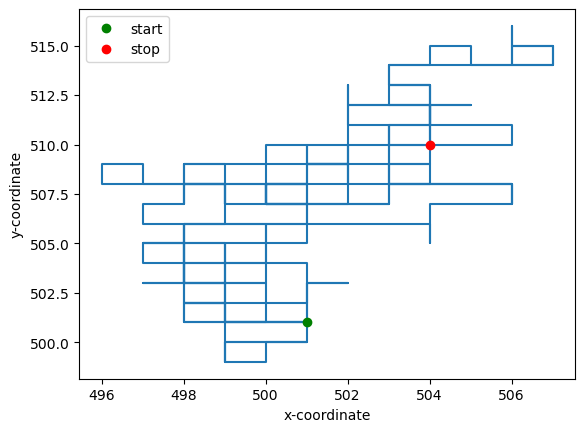

In [7]:
idx_traj = 1
idxx = [tup[1] for tup in lin2cart.(res2[idx_traj], Ref(L2.dims))]
idxy = [tup[2] for tup in lin2cart.(res2[idx_traj], Ref(L2.dims))]
close("all")
plot(idxx, idxy)
plot(idxx[1], idxy[1], "go",label="start")
plot(idxx[end],  idxy[end], "ro",label="stop")
# xticks(collect(minimum(idxx):1:maximum(idxx)))
# yticks(collect(minimum(idxy):1:maximum(idxy)))
legend()
# grid(which= "major")
xlabel("x-coordinate")
ylabel("y-coordinate")
gcf()

We now define a function to compute the average euclidean distance from the starting point of our trajectory. Note that to translate LinearIndices into the Cartesian representation, we use the `lin2cart` method defined in the file `lattice.jl`.

In [8]:
function trajdiffusion(vtraj::Vector{Vector{Int}}, L::Lattice)
    ntraj = length(vtraj)
    ave = zeros(length(vtraj[1]))
    va = similar(ave)
    for t in 1:length(vtraj[1])
        media = 0.0
        mom2 = 0.0
        for i in 1:ntraj
            p0 = lin2cart(vtraj[i][1],L.dims)
            pt = lin2cart(vtraj[i][t],L.dims)
            dt = sqrt(sum((p0 .- pt).^2))
            media += dt
            mom2 += dt^2
        end
        ave[t] = media/ntraj
        va[t] = (mom2-media*media/ntraj)/ntraj
    end
    ave,va
end

trajdiffusion (generic function with 1 method)

In [17]:
function trajRMSD(vtraj::Vector{Vector{Int}}, L::Lattice)
    ntraj = length(vtraj)
    ave = zeros(length(vtraj[1]))
    for t in 1:length(vtraj[1])
        media = 0.0
        for i in 1:ntraj
            p0 = lin2cart(vtraj[i][1],L.dims)
            pt = lin2cart(vtraj[i][t],L.dims)
            dt = sum((p0 .- pt).^2)
            media += dt
        end
        ave[t] = sqrt(media/ntraj)
    end
    ave
end

trajRMSD (generic function with 1 method)

In [10]:
m1,e1 = trajdiffusion(res1,L1); # 2D statistics
m2,e2 = trajdiffusion(res2,L2); # 2D statistics
m3,e3 = trajdiffusion(res3,L3); # 3D statistics

We can now plot the average distance as a function of time for the $d=1,2,3$. From the theory of random walks we indeed expect that $\langle |\vec R(t)| \rangle = K_d \sqrt t$, where $K_d$ is a constant which depends on the dimension. 

It turns out that

$$
K_d = \sqrt{ \frac 2d} \frac{\Gamma\left( \frac{d+1}{2}\right)}{\Gamma\left( \frac d2 \right)}
$$

If you feel strong at combinatorial computation you could try to derive this scaling law by yourself.

### RMSD
Let $\vec R(t)$ be the vector of coordinates $\vec x (0) - \vec x(t)$ i.e. the end to end vector of our position at time $t$. $\vec R(t) = \sum_{i=1}^t \vec l_i$ and $l_i$ is the vector of the i-th step (what is the structure of the $\vec l_i$?). As we have seen in the 1-d case, it holds that:

$$ 
\langle \vec l_i \rangle = \vec 0
$$

$$ 
\langle \vec l_i \cdot \vec l_j \rangle = \delta_{ij} 
$$

From these considerations we have that Root Mean Square Deviation (RMSD), can be computed as:

$$
RMSD(t) = \sqrt{\langle \vec R(t)^2  \rangle} = \sqrt{\langle \vec R(t) \cdot \vec R(t) \rangle} 
= \sqrt{\sum_{i,j=1}^t \langle \vec l_i \vec l_j\rangle} = \sqrt{t}
$$

**Warning:** $RMSD(t)$ does not coincide with $D(t)$

$$
D(t)= \langle |\vec R(t)| \rangle = \langle \sqrt{\vec R(t) \cdot \vec R(t)} \rangle
$$

Let $R_\alpha$ $\alpha={1,\dots,d}$ be the $\alpha$-th component of the vector. Of course:
$R_\alpha(t) = P_\alpha(t)-M_\alpha(t)$ where $P_\alpha(t)$ (resp $M_\alpha$) is the number of plus (resp. minus) accumulated in the $\alpha$ coordinate. Both $M_\alpha$ and $P_\alpha$ follow a multinomial distribution: 
$$
Pr(P_\alpha(t) = k) = {t\choose k}\left(\frac{1}{2d}\right)^k \left(1-\frac{1}{2d}\right)^{t-k}\,
$$
which is the same for $M_\alpha(t)$. Note that, for $t$ large enough, the binomial tends to a Poisson of the same average:

$$
\langle P_\alpha(t) \rangle = \frac{t}{2d}.
$$

So we can assume that both $M_\alpha(t),P_\alpha(t)$ are Poisson with $\lambda=\frac{t}{2d}$ for all $\alpha \in [1,\dots,d]$. Also, for $t$ large enough it can be well described by a Gaussian distribution of average $\mu=\frac{t}{2d}$ and variance $\sigma^2 = \mu = \frac{t}{2d}$. So the variable $R_\alpha(t)$ is well approximated by a Gaussian distribution of average:

$$
 \langle R_\alpha(t) \rangle= 0\quad,\quad \mathrm{Var}(R_\alpha(t)) = 2\mu = \frac{t}{d} 
$$

Now, the variable 

$$|\vec R(t)| =  \sqrt {\sum_{\alpha=1}^d R^2_\alpha(t)}$$ 

is the square root of sum of the square of $d$ Gaussian-distributed numbers. We also know that the sum of the square of $d$ **standard** Gaussian-distributed numbers (with zero mean and unitary variance) is the [$\chi$-distribution](https://en.wikipedia.org/wiki/Chi_distribution). So it means that an auxiliary variable $Y$

$$ 
Y = \sqrt {\frac dt \sum_{\alpha=1}^d R^2_\alpha(t)}
$$

is $\chi$-distributed with mean $\sqrt 2\frac{\Gamma(\frac{d+1}{2})}{\Gamma(\frac{d}{2})}$, implying that 

$$
D(t) = \langle|\vec R(t)|\rangle = \sqrt{\frac{2}{d}} \frac{\Gamma(\frac{d+1}{2})}{\Gamma(\frac{d}{2})}\sqrt t
$$





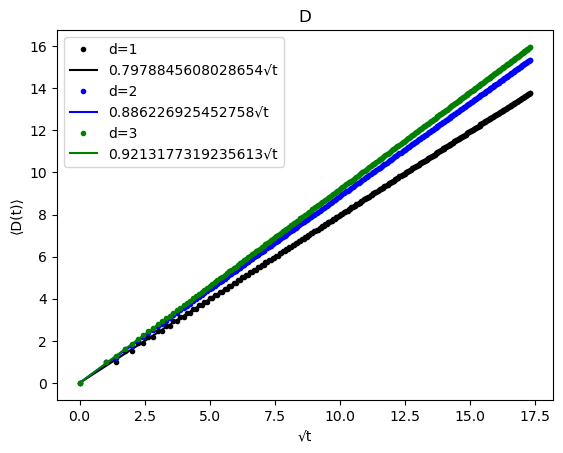

In [41]:
f(d) = sqrt(2/d)*gamma((d+1)/2)/gamma(d/2)
t=0:length(m2)-1
close("all")
title("D")
plot(sqrt.(t),m1,".k")
plot(sqrt.(t),f(1)*sqrt.(t),"-k")
plot(sqrt.(t),m2,".b")
plot(sqrt.(t),f(2)*sqrt.(t),"-b")
plot(sqrt.(t),m3,".g")
plot(sqrt.(t),f(3)*sqrt.(t),"-g")
xlabel("√t")
ylabel("⟨D(t)⟩")
plt.legend(["d=1","$(f(1))√t","d=2","$(f(2))√t","d=3", "$(f(3))√t"])
# xscale(:log)
# yscale(:log)
gcf()

In [16]:
using LinearAlgebra
p = lin2cart.(res1[1], Ref(L2.dims))[1]
norm(p,2),sqrt(p[1]^2+p[2]^2)




(708.5224061382957, 708.5224061382957)

In [ ]:
m1rmsd=trajRMSD(res1,L1)
m2rmsd=trajRMSD(res2,L2)
m3rmsd=trajRMSD(res3,L3);

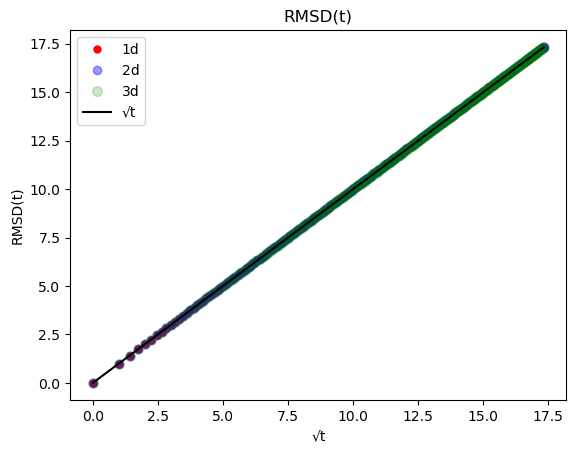

In [40]:
t = 0:length(m1rmsd)-1
close("all")
title("RMSD")
plot(sqrt.(t), m1rmsd, ".r", label="1d",ms=10)
plot(sqrt.(t), m2rmsd, ".b", label="2d",ms=12,alpha=0.4)
plot(sqrt.(t), m3rmsd, ".g", label="3d",ms=14, alpha=0.2)
plot(sqrt.(t), sqrt.(t), "-k", label="√t")
xlabel("√t")
ylabel("RMSD(t)")
legend()
gcf()
